In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms.community import (
    k_clique_communities,
    louvain_communities,
    greedy_modularity_communities
)
from networkx import edge_betweenness_centrality as betweenness
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
sf_df = pd.read_csv('../data/software/Digital_Software_v1_00.tsv', sep='\t')

In [3]:
sf_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


In [4]:
sf_df.nunique()

marketplace               1
customer_id           94099
review_id            101836
product_id             2995
product_parent         2981
product_title          2639
product_category          1
star_rating               5
helpful_votes           283
total_votes             290
vine                      1
verified_purchase         2
review_headline       69680
review_body           98420
review_date            2198
dtype: int64

In [5]:
# Create a dictionary from train data
# key -> product
# value -> concatenated reviews by various users for the product
# Finally extract list of unique produccts and concatenated reviews from the dictionary
product_reviews_dict = {}
for index, row in sf_df.iterrows():
    if row['product_id'] in product_reviews_dict:
        product_reviews_dict[row['product_id']] = product_reviews_dict[row['product_id']] + " " + str(row['review_body'])
    else:
        product_reviews_dict[row['product_id']] = row['review_body']
products_list = list(product_reviews_dict.keys())
reviews_list = list(product_reviews_dict.values())

In [6]:
# Tokenize the review text using CountVectorizer to create a document term matrix (product vs words in review)
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews_list)

In [7]:
# Reduce the dimensionality of document term matrix
n_components = [num for num in range(200,2500, 100)]
explained_variance = {}

for n in n_components:
    svd = TruncatedSVD(n_components=n, n_iter=5)
    X_red = svd.fit_transform(X)
    explained_variance[n] = svd.explained_variance_ratio_.sum()

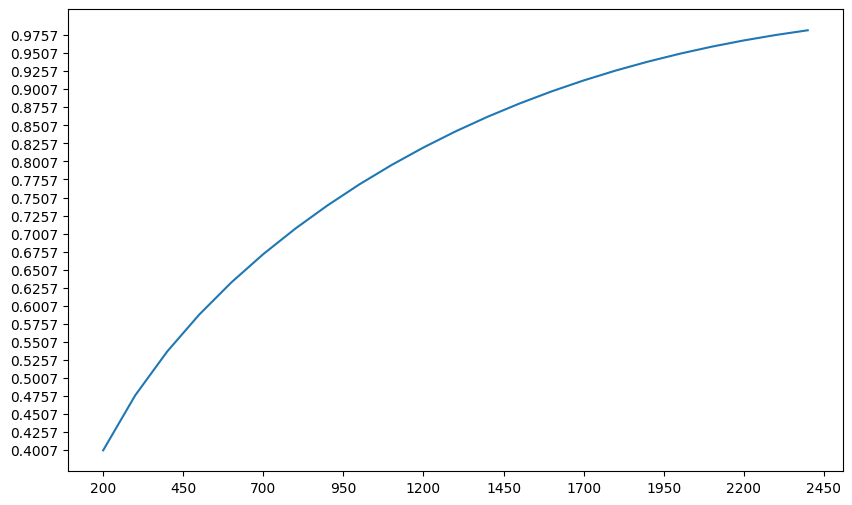

In [8]:
plt.figure(figsize=(10,6))
plt.plot(n_components, list(explained_variance.values()))
plt.xticks(np.arange(min(n_components), max(n_components)+100, 250))
plt.yticks(np.arange(min(explained_variance.values()), max(explained_variance.values()), 0.025))
plt.show()

In [9]:
# Reduce the dimensionality of document term matrix
svd = TruncatedSVD(n_components=2200, n_iter=5)
X_red = svd.fit_transform(X)
X_red.shape

(2995, 2200)

In [10]:
# Create an adjacency matrix for graph using kneighbors_graph with speciefied number of neighbors
X_graph_adj = kneighbors_graph(X_red, 10, mode='distance', n_jobs=-1)

In [11]:
# Create a networkX graph from the adjacency matrix
main_graph = nx.convert_matrix.from_scipy_sparse_array(X_graph_adj)

# Create a label mapping between products and indices created in the graph
label_mapping = dict(zip(main_graph.nodes(), products_list))

# Relabel the indices in the graph with product names 
main_graph = nx.relabel_nodes(main_graph, label_mapping)
print(main_graph)

Graph with 2995 nodes and 25889 edges


In [12]:
# nx.draw(main_graph, with_labels=True)

In [13]:
# function to calculate pagerank for the nodes in a community within a graph
def getPageRankOfCommunity(G, community_nodes):
    community_graph = G.subgraph(community_nodes)
    return nx.pagerank(community_graph, alpha=0.85, weight='weight')

In [22]:
# Instanciate K-Clique algorithm and get the communities 
k_clique = k_clique_communities(main_graph, 8)

# Transform the communities obtained into a dictionary with
# key -> communityId
# value -> list of nodes in the community
kc_dict = dict(enumerate(k_clique))

# Create a dictionary with
# key -> product
# value -> Id of the community the product belongs to
kc_product_comm_dict = {}
for comm, products in kc_dict.items():
    for product in products:
        kc_product_comm_dict[product] = comm

# Calculate pagerank for the nodes in each community and create a dictionary where
# key -> communityId
# value -> list of tuples (product, pagerank) sorted in descending order of pagerank
kc_community_pagerank_dict = {}
for comm, nodes in kc_dict.items():
    page_rank_dict = getPageRankOfCommunity(main_graph, nodes)
    kc_community_pagerank_dict[comm] = sorted(page_rank_dict.items(), key=lambda kv: kv[1], reverse=True)
# print(kc_community_pagerank_dict)

In [15]:
# function to return the recommendation of a product using the communities specified
# product_comm_dict and community_pagerank_dict can be results of any community detection alorithm (K-clique or girvan-newman)
def getProductRecommendations(product, product_comm_dict, community_pagerank_dict):
    if product in product_comm_dict:
        recommendation_list = []
        comm_nodes = community_pagerank_dict[product_comm_dict[product]]
        comm_nodes = [(p, pr*cosine_similarity(X_red[list(products_list).index(p)].reshape(1,-1), X_red[list(products_list).index(product)].reshape(1,-1))) for p, pr in comm_nodes]
        comm_nodes = sorted(comm_nodes, key=lambda kv: kv[1], reverse=True)
        for product_id, pagerank in comm_nodes:
            if len(recommendation_list) >= 5:
                break
            elif product_id != product:
                recommendation_list.append(product_id)
            else:
                continue
        return recommendation_list
    else:
        return []

In [16]:
train_df, test_df = train_test_split(sf_df, test_size=0.02)

In [17]:
test_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
48291,US,50681115,R1OSAQ23O2W6UO,B00H9A60O4,608720080,Avast Free Antivirus 2015 [Download],Digital_Software,5,0,0,N,N,Read this it's good for you!,Been using this Anti-virus for years. easy to ...,2014-08-06
72560,US,46728687,R3K04R75QBXM84,B00FFIO0NA,386795082,"TurboTax Premier Fed, Efile and State 2013",Digital_Software,4,2,4,N,Y,Software fine Download process not so good,I purchased the product yesterday 12/22 and do...,2013-12-23
20150,US,15761870,RJN2MNMEWCNW6,B00PG8FOSY,801860929,Block Financial H&R Block Tax Software 14 Delu...,Digital_Software,1,0,0,N,Y,DOES NOT include state e-file!!!,I purchased this software because it included ...,2015-03-15
52061,US,52604113,R14WKALA581EW0,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,4,0,0,N,Y,install it and then you will be good to go for...,"A user for many years. Buy it, install it and...",2014-06-30
63760,US,34529613,R36NYWLAFUQMIS,B00H99ZDSY,219559097,"avast! Pro Antivirus 2014 (1 PC, 1 Year) [Down...",Digital_Software,1,0,1,N,N,You have been warned! Avast is a VIRUS,Avast is a Virus! Their whole communication sy...,2014-03-08


In [18]:
def getRecommendedProductNames(recommendations, original_df):
    recommended_product_names = []
    for product_id in recommendations:
        recommended_product_names.append((original_df[original_df['product_id'] == product_id]['product_title'].iloc[0], product_id))
    return recommended_product_names

In [23]:
with open('../data/software/recommendations_kc_8.txt', 'w') as f:
    for index, row in test_df.iterrows():
        recommendations = getProductRecommendations(row['product_id'], kc_product_comm_dict, kc_community_pagerank_dict)
        rec_products = getRecommendedProductNames(recommendations, sf_df)
        f.write(f"Recommended items for Product: {row['product_title']} - {row['product_id']} are {rec_products} \n")

In [20]:
# Instanciate Louvain algorithm and get the communities 
louvain = louvain_communities(main_graph)

# Transform the communities obtained into a dictionary with
# key -> communityId
# value -> list of nodes in the community
louvain_dict = dict(enumerate(louvain))

# Create a dictionary with
# key -> product
# value -> Id of the community the product belongs to
louvain_product_comm_dict = {}
for comm, products in louvain_dict.items():
    for product in products:
        louvain_product_comm_dict[product] = comm

# Calculate pagerank for the nodes in each community and create a dictionary where
# key -> communityId
# value -> list of tuples (product, pagerank) sorted in descending order of pagerank
louvain_community_pagerank_dict = {}
for comm, nodes in louvain_dict.items():
    page_rank_dict = getPageRankOfCommunity(main_graph, nodes)
    louvain_community_pagerank_dict[comm] = sorted(page_rank_dict.items(), key=lambda kv: kv[1], reverse=True)
# print(kc_community_pagerank_dict)

In [21]:
with open('../data/software/recommendations_louvain.txt', 'w') as f:
    for index, row in test_df.iterrows():
        recommendations = getProductRecommendations(row['product_id'], louvain_product_comm_dict, louvain_community_pagerank_dict)
        rec_products = getRecommendedProductNames(recommendations, sf_df)
        f.write(f"Recommended items for Product: {row['product_title']} - {row['product_id']} are {rec_products} \n")